<a href="https://colab.research.google.com/github/eliassalazarb/FisicaComputacional1/blob/main/Evaluaci%C3%B3n1/Evaluaci%C3%B3n1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Parte 1. Construcción de una Serie de Tiempo.**

Bibliotecas

In [1]:
#Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

#Eliminar mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [27]:
#Dirección del archivo.
url = 'https://raw.githubusercontent.com/RaulACortez/FisicaComputacional1/main/FisicaComputacional1/Evaluaci%C3%B3n1/Hawaii.txt'

#Nombres para las columnas.
my_cols = ['site_code', 'year', 'month', 'day', 'hour', 'minute', 'second', 'time_decimal', 'Concentracion de CO2', 'value_std_dev', 'nvalue', 'latitude', 'longitude', 'altitude', 'elevation', 'intake_height', 'qcflag']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=152, skipfooter=0, engine='python')

#Creamos una copia y conservamos el original.
df_hawaii = df_dist.copy()

#Reemplazamos los textos "Nulo" por espacio en blanco.
str_Nulo = -999.99
df_a = df_hawaii.replace(to_replace=str_Nulo, value='NaN', regex=True)

#Convertimos los valores a numeros flotantes.
cols_list = ['site_code', 'year', 'month', 'day', 'hour', 'minute', 'second', 'time_decimal', 'Concentracion de CO2', 'value_std_dev', 'nvalue', 'latitude', 'longitude', 'altitude', 'elevation', 'intake_height', 'qcflag']
for cols in cols_list:
  df_a [cols] = pd.to_numeric(df_a [cols], errors='coerce')

#Volvemos a hacer una copia.
df_a2 = df_a.copy()

df_a2['Fecha'] = pd.to_datetime(df_a2[['year','month','day']]
                   .astype(str).apply(' '.join, 1), format='%Y %m %d')

df_a2['Fecha'] = (pd.to_datetime(df_a2['year'].astype(str) + '-' +
                                  df_a2['month'].astype(str) + '-' +
                                  df_a2['day'].astype(str)))

In [28]:
df_data = df_a2.copy()
df_data.info()
print(df_data.head())
print(df_data.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17166 entries, 0 to 17165
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   site_code             0 non-null      float64       
 1   year                  17166 non-null  int64         
 2   month                 17166 non-null  int64         
 3   day                   17166 non-null  int64         
 4   hour                  17166 non-null  int64         
 5   minute                17166 non-null  int64         
 6   second                17166 non-null  int64         
 7   time_decimal          17166 non-null  float64       
 8   Concentracion de CO2  13936 non-null  float64       
 9   value_std_dev         17166 non-null  float64       
 10  nvalue                17166 non-null  int64         
 11  latitude              17166 non-null  float64       
 12  longitude             17166 non-null  float64       
 13  altitude        

In [29]:
df_data = df_data.copy()
#Indice del DataFrame a que sea la variable 'Fecha'
df_data = df_data.set_index('Fecha')
#Datos, 1980-2019
df_data2 = df_data[(df_data['year'] >= 1980) & (df_data['year'] < 2020)]
df_data2.head()

,site_code,year,month,day,hour,minute,second,time_decimal,Concentracion de CO2,value_std_dev,nvalue,latitude,longitude,altitude,elevation,intake_height,qcflag
Fecha,,,,,,,,,,,,,,,,,
1980-01-01,NaN,1980,1,1,0,0,0,1980.000000,337.85,0.12,15,19.536,-155.576,3437.0,3397.0,40.0,NaN
1980-01-02,NaN,1980,1,2,0,0,0,1980.002732,337.32,0.35,11,19.536,-155.576,3437.0,3397.0,40.0,NaN
1980-01-03,NaN,1980,1,3,0,0,0,1980.005464,337.75,0.05,15,19.536,-155.576,3437.0,3397.0,40.0,NaN
1980-01-04,NaN,1980,1,4,0,0,0,1980.008197,337.70,0.04,15,19.536,-155.576,3437.0,3397.0,40.0,NaN
1980-01-05,NaN,1980,1,5,0,0,0,1980.010929,337.65,0.08,15,19.536,-155.576,3437.0,3397.0,40.0,NaN


In [31]:
df_dataco2 = df_data2.drop(['site_code', 'year', 'month', 'day', 'hour', 'minute', 'second', 'time_decimal', 'value_std_dev', 'nvalue', 'latitude', 'longitude', 'altitude', 'elevation', 'intake_height', 'qcflag'], axis=1)
df_dataco2.head(10)

,Concentracion de CO2
Fecha,
1980-01-01,337.85
1980-01-02,337.32
1980-01-03,337.75
1980-01-04,337.70
1980-01-05,337.65
1980-01-06,337.25
1980-01-07,337.86
1980-01-08,337.31
1980-01-09,NaN


In [32]:
df_dataco2.ffill(axis = 0, inplace=True)

#**Parte 2. Análisis de la Serie de Tiempo.**

In [7]:
#Función para probar la estacionaridad
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    #Definir el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [33]:
start, end = '1980-01', '2019-12'

ts_dataco2 = df_dataco2.loc[start:end].copy()
ts_dataco2.head()

,Concentracion de CO2
Fecha,
1980-01-01,337.85
1980-01-02,337.32
1980-01-03,337.75
1980-01-04,337.70
1980-01-05,337.65


In [34]:
ts_dataco2['Concentracion de CO2'].head()

Fecha
1980-01-01    337.85
1980-01-02    337.32
1980-01-03    337.75
1980-01-04    337.70
1980-01-05    337.65
Name: Concentracion de CO2, dtype: float64

In [35]:
ts_test = ts_dataco2['Concentracion de CO2'].copy()

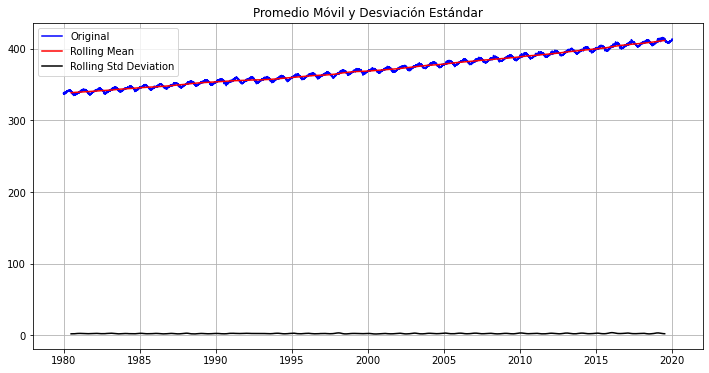

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                    -1.014427
p-value                            0.747966
#Lags Used                        42.000000
Number of Observations Used    14567.000000
Critical Value (1%)               -3.430799
Critical Value (5%)               -2.861738
Critical Value (10%)              -2.566876
dtype: float64


In [36]:
#Prueba de estacionaridad 
test_stationarity(ts_test)

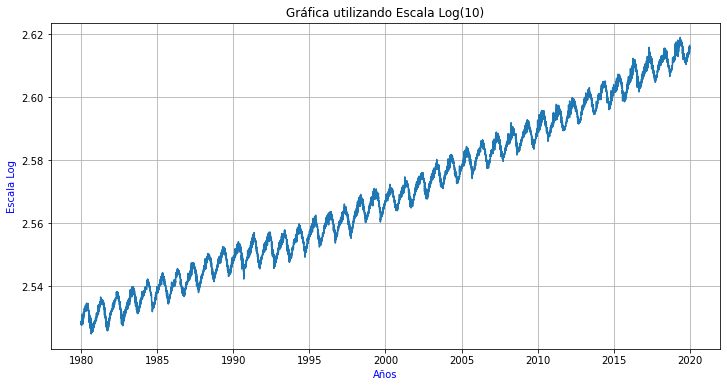

In [37]:
#Promedio móvil
ts_test_log=np.log10(ts_test)
plt.plot(ts_test_log)
plt.xlabel('Años', color='b')
plt.ylabel('Escala Log', color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

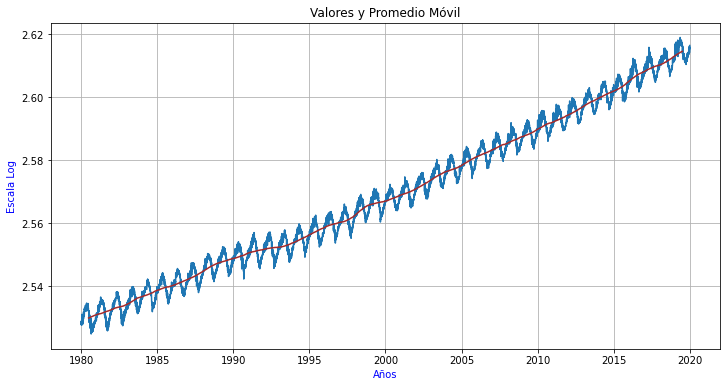

In [38]:
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [39]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
1980-01-01   NaN
1980-01-02   NaN
1980-01-03   NaN
1980-01-04   NaN
1980-01-05   NaN
Name: Concentracion de CO2, dtype: float64

In [40]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
1980-07-01    0.002344
1980-07-02    0.002353
1980-07-03    0.002196
1980-07-04    0.002207
1980-07-05    0.002192
Name: Concentracion de CO2, dtype: float64

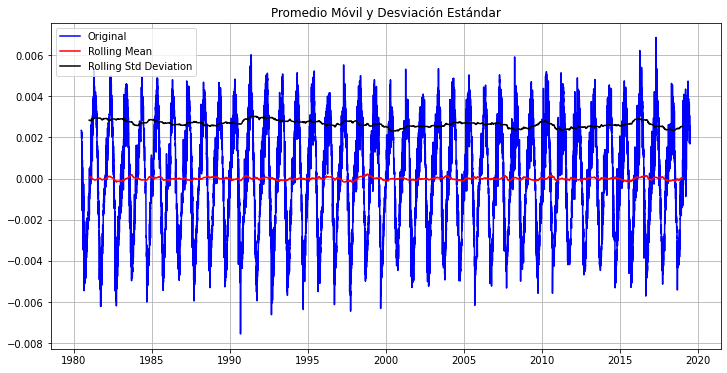

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.400423e+01
p-value                        3.813700e-26
#Lags Used                     4.200000e+01
Number of Observations Used    1.420300e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [41]:
#Estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff)

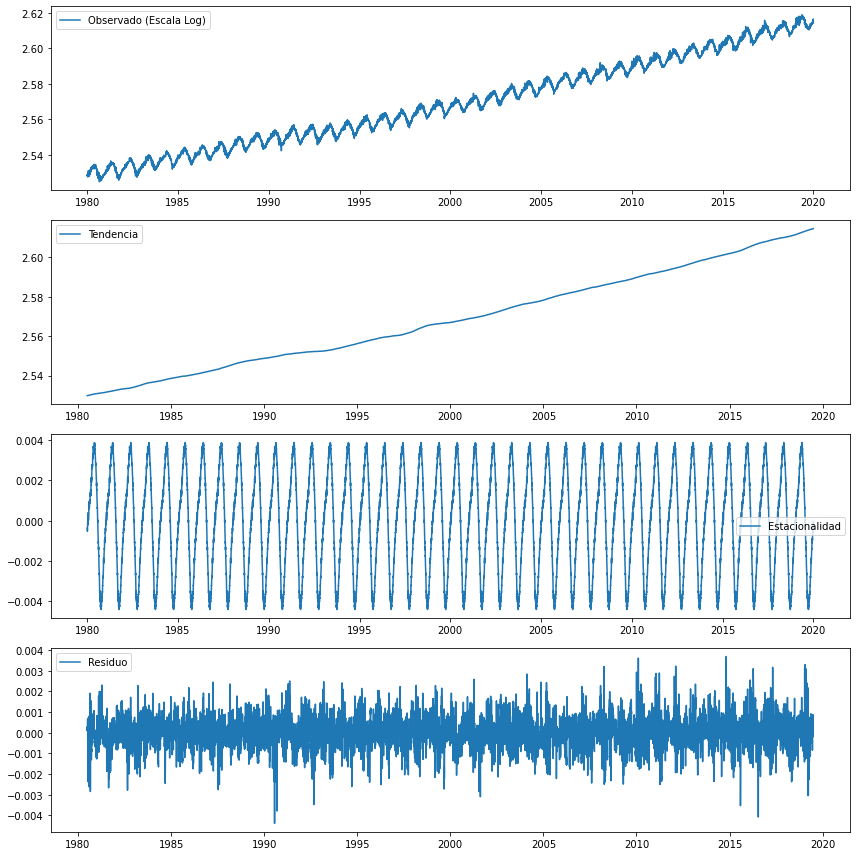

In [42]:
decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

#Colocar gráficas lo más cercanas posibles
plt.tight_layout();

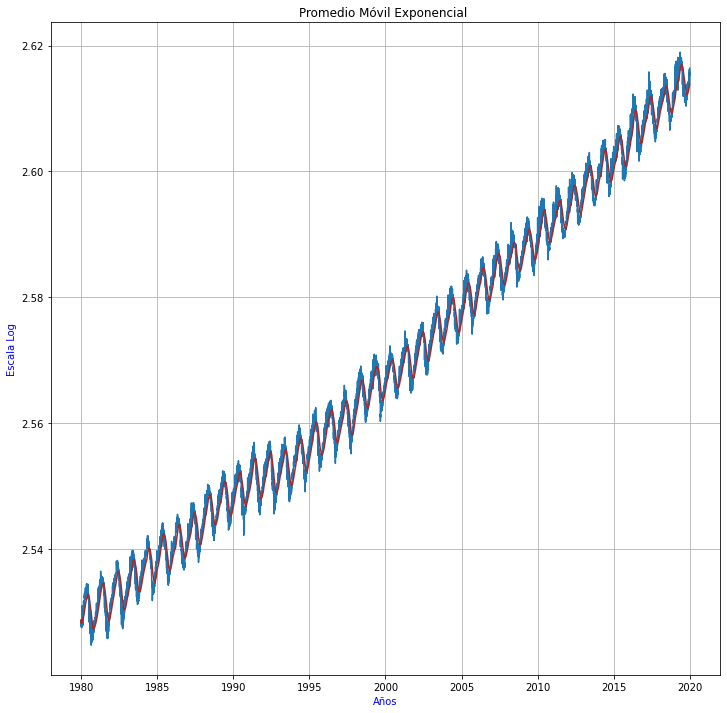

In [43]:
#Usando promedios móviles exponenciales, 

EWM_avg = ts_test_log.ewm(halflife=30).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

In [44]:
EWM_avg.head()

Fecha
1980-01-01    2.528724
1980-01-02    2.528379
1980-01-03    2.528453
1980-01-04    2.528473
1980-01-05    2.528472
Name: Concentracion de CO2, dtype: float64

In [45]:
#Estacionarida de la diferencia 
ts_test_log_EWM_avg_diff = ts_test_log - EWM_avg

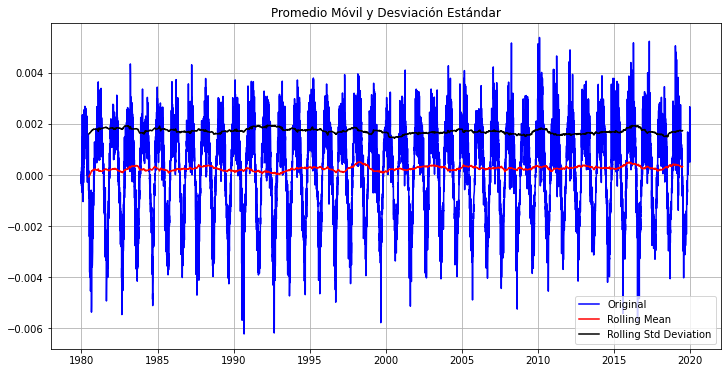

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.193061e+01
p-value                        4.791202e-22
#Lags Used                     4.200000e+01
Number of Observations Used    1.456700e+04
Critical Value (1%)           -3.430799e+00
Critical Value (5%)           -2.861738e+00
Critical Value (10%)          -2.566876e+00
dtype: float64


In [46]:
#Estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff)

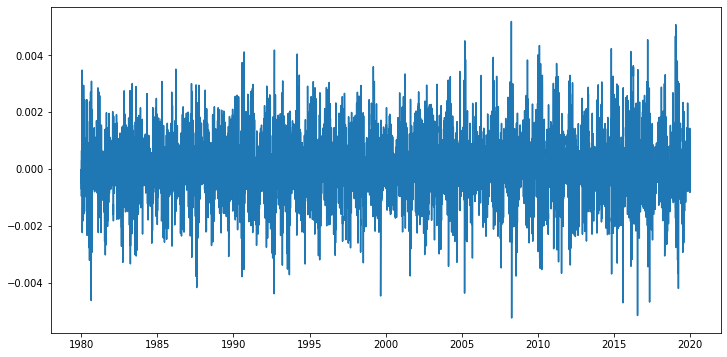

In [47]:
#Diferenciamos
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);

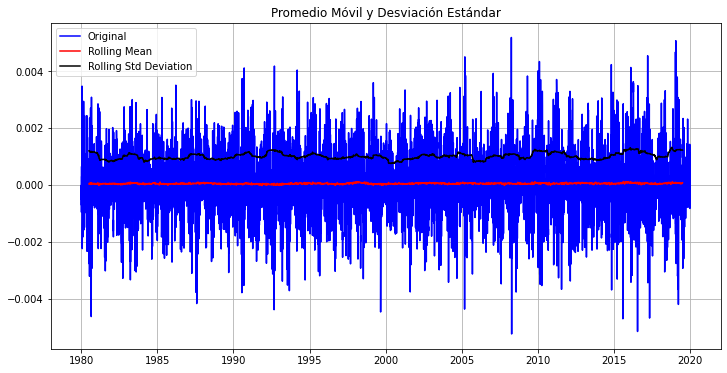

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.002234e+01
p-value                        1.666271e-17
#Lags Used                     4.200000e+01
Number of Observations Used    1.456000e+04
Critical Value (1%)           -3.430799e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64


In [48]:
#Estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

In [49]:
#Datos utilizados
len(ts_test_log_diff)

14603

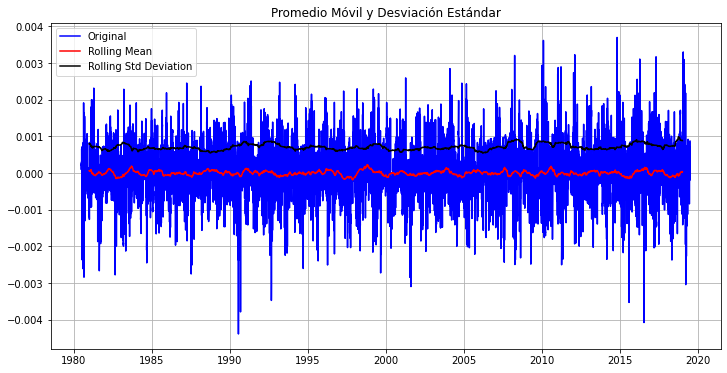

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -19.156045
p-value                            0.000000
#Lags Used                        21.000000
Number of Observations Used    14224.000000
Critical Value (1%)               -3.430810
Critical Value (5%)               -2.861743
Critical Value (10%)              -2.566878
dtype: float64


In [50]:
#Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria

ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)